# Curve estimating using mono depth network and semantic segmentation

## Semantic segmentation

In [2]:
import sys
print('Python:', sys.version)

# import libraries for machine learning
import torch
import torchvision
print('PyTorch:', torchvision.__version__)
print('Cuda is available' if torch.cuda.is_available() else 'Cuda is not avalaiable')

# import libraries for computer vision
import cv2 as cv
import numpy as np
print('Numpy:', np.__version__)
print('OpenCV:', cv.__version__)

# import libraries for visualization
import matplotlib
import matplotlib.pyplot as plt
print('matplotlib:', matplotlib.__version__)

# sys.path.append('../../')
print('sys.path:', sys.path)

Python: 3.6.9 (default, Aug  8 2019, 01:14:55) 
[GCC 7.4.0]
PyTorch: 0.4.0
Cuda is available
Numpy: 1.18.1
OpenCV: 4.2.0
matplotlib: 3.1.1
sys.path: ['/usr/local/lib/python36.zip', '/usr/local/lib/python3.6', '/usr/local/lib/python3.6/lib-dynload', '', '/home/sid1057/.local/lib/python3.6/site-packages', '/usr/local/lib/python3.6/site-packages', '/home/sid1057/.local/lib/python3.6/site-packages/IPython/extensions', '/home/sid1057/.ipython']


create dataset transformation for segmentation

In [3]:
import torchvision.transforms as T

def torch_unsqueeze(input):
    return input.unsqueeze(0)

def CityScapesSemanticTarget(input):
    mask = np.asarray(input).astype(np.uint8)
    target = np.zeros((
            mask.shape[0],
            mask.shape[1]
    ), dtype=np.long)
    
    for city_class in torchvision.datasets.Cityscapes.classes:
        channel = city_class.id
        category = city_class.category_id
        if channel < 0:
            channel = len(torchvision.datasets.Cityscapes.classes)-1
        target[np.where(mask == channel)] = category
        
    return target

input_transform = T.Compose([
    #T.ToPILImage(),  # uncomment for usage with opencv images
    T.ToTensor(),
])

target_transform = T.Compose([
    #T.ToPILImage(),  # uncomment for usage with opencv images
    CityScapesSemanticTarget,
    T.ToTensor(),
])

def target_in_net_transform(x):
    return x.type(torch.LongTensor)[0]

load KITTI dataset (some dataset with CityScapes annotations)

In [5]:
train_dataset = torchvision.datasets.Cityscapes(
    '../../data/KITTI_TRAIN', split='train', mode='fine', target_type='semantic',
    transform=input_transform, target_transform=target_transform)

validation_dataset = torchvision.datasets.Cityscapes(
    '../../data/KITTI_VAL', split='train', mode='fine', target_type='semantic',
    transform=input_transform, target_transform=target_transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1)
val_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=1)
print('train dataset')
print(train_dataset)

print('validation dataset')
print(validation_dataset)
g, smnt = train_dataset[0]
print('input shape  :', g.shape)
print('target shape :', smnt.shape)

Try default pretrained deep lab with resnet101 backend

In [5]:
print (np.array(set([i.category for i in torchvision.datasets.Cityscapes.classes])))

{'void', 'flat', 'nature', 'human', 'object', 'construction', 'vehicle', 'sky'}


In [6]:
from torchvision.models._utils import IntermediateLayerGetter
import torchvision.models.resnet as resnet

from torch.nn import functional as F

from collections import OrderedDict
from torchvision.models.segmentation.deeplabv3 import DeepLabHead

squeeze = torchvision.models.squeezenet.squeezenet1_1(pretrained=True).eval()

class DeepSqueeze(torch.nn.Module):
    def __init__(self, num_classes):
        super(DeepSqueeze, self).__init__()
        backbone = squeeze.features

        classifier = DeepLabHead(512, num_classes)

        self.backbone = backbone
        self.classifier = classifier
        self.aux_classifier = None

    def forward(self, x):
        input_shape = x.shape[-2:]
        features = self.backbone(x)

        result = OrderedDict()
#         x = features["out"]
        x = features
        x = self.classifier(x)
        x = F.interpolate(x, size=input_shape, mode='bilinear', align_corners=False)

        return x

In [7]:
# Define the helper function
def decode_cityscapes_out(image, category=True):
    city_colors = np.asarray([i.color for i in torchvision.datasets.Cityscapes.classes])
    if category:
        city_colors = np.asarray([
            (128, 64, 128),
            (0, 0, 0),
            (248, 128, 248),
            (70, 70, 70),
            (153, 153, 153),
            (107, 142, 35),
            (70, 130, 180),
            (220, 20, 60),
            (0, 0, 142)])
    r = np.zeros_like(image).astype(np.uint8)
    g = np.zeros_like(image).astype(np.uint8)
    b = np.zeros_like(image).astype(np.uint8)
  
    for l in range(len(city_colors)):
        idx = image == l
        r[idx] = city_colors[l, 0]
        g[idx] = city_colors[l, 1]
        b[idx] = city_colors[l, 2]
    
    rgb = np.stack([r, g, b], axis=2)
    return rgb

In [8]:
net = DeepSqueeze(35).eval().cuda(2).half()

In [1]:
net.load_state_dict(torch.load('CADAR/models/absDLSQUEEZE_KITTI.pth'))

NameError: name 'net' is not defined

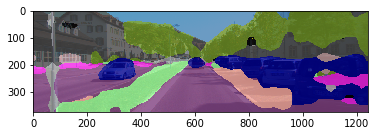

In [10]:
img, mask = None, None
for i, (input, target) in enumerate(train_loader):
    if i < 1:
        continue
    output = net(input.cuda(2).half())
    output = torch.argmax(output.squeeze(), dim=0).detach().cpu().numpy()
    output = decode_cityscapes_out(output,category=False)
    
    input = np.transpose((input.cpu().numpy()[0]*255).astype(np.uint8), (1, 2, 0))
    img = input
    mask = output
    plt.imshow(cv.addWeighted(input, 0.2, output, 0.8, 0))
    plt.show()
    break

In [11]:
# fine tune

In [12]:
scale=100
height=25*scale
width=10*scale

In [13]:
M = np.asarray([
    [-1.89105478e-01, -1.86105298e+00, 5.77265449e+02],
    [3.47848597e-01, -9.25968510e+00, 2.64186035e+03],
    [1.63468194e-04, -3.72569678e-03, 1.00000000e+00]])

In [14]:
img = cv.imread('../../data/0665.png')
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
print(img.shape)

(480, 640, 3)


In [15]:
dst=cv.warpPerspective(img,M,(width,height))


In [142]:
input_video_path = '../../data/VIDEO22.AVI'
input_cap = cv.VideoCapture(input_video_path)

In [143]:
output_video_path = '../../results/semantic/deeplab_resnet50_kitti_X264.mp4'
output_bird_path = '../../results/semantic/bird.mp4'
output_road_path = '../../results/semantic/road.mp4'
output_front_path = '../../results/semantic/front.mp4'

fourcc = cv.VideoWriter_fourcc(*'XVID')
fps = input_cap.get(cv.CAP_PROP_FPS)
fps = 10
print('fps:', fps)

output_bird = cv.VideoWriter(output_bird_path, fourcc, fps, (width//2, height//2))
output_front = cv.VideoWriter(output_front_path, fourcc, fps, (640, 480))

fps: 10


In [144]:
# cell
import math

In [146]:
index = 0

matplotlib.rcParams['figure.figsize'] = [12.8, 9.6]

while True:
    flag, frame = input_cap.read()
    
    index += 1
    print(index, end='\r')
#     break
#     if index < 255:
#         continue

    if frame is None or flag is None:
        output_bird.release()
        break
    
    out_tensor = net(input_transform(cv.cvtColor(frame, cv.COLOR_BGR2RGB)).cuda(2).unsqueeze(0).half())
    om = torch.argmax(out_tensor.squeeze(), dim=0).detach().cpu().numpy()
    city_mask = decode_cityscapes_out(om, category=False)
    road_mask = cv.inRange(
        city_mask,
        torchvision.datasets.Cityscapes.classes[7].color, torchvision.datasets.Cityscapes.classes[7].color)
    city_mask = cv.cvtColor(city_mask, cv.COLOR_BGR2RGB)
    
    result = cv.addWeighted(frame, 1, city_mask, 0.4, 0)
    result = cv.warpPerspective(result,M,(width,height))
    
    road_mask = cv.warpPerspective(road_mask,M,(width,height))

    
    road_mask = cv.copyMakeBorder(road_mask, 5, 5, 5, 5, cv.BORDER_CONSTANT, 0)
    dist_transform = cv.distanceTransform(road_mask,cv.DIST_L2,5)
#     plt.imshow(dist_transform)
#     plt.show()
    a = cv.Sobel(1*dist_transform,cv.CV_8U,1,0,ksize=5)
    a = cv.Sobel(-1*a,cv.CV_8U,1,0,ksize=5)
    
    b = cv.Sobel(-1*dist_transform,cv.CV_8U,1,0,ksize=5)
    b = cv.Sobel(1*b,cv.CV_8U,1,0,ksize=5)
    a = cv.inRange(a, 255, 255)
    b = cv.inRange(b, 255, 255)
    dist_transform = cv.bitwise_and(
        cv.dilate(a, np.ones((3,3), dtype=np.uint8)), b)
    
    contours,hierarchy = cv.findContours(dist_transform, 1, 2)
    if contours is None or len(contours) == 0:
        continue
        
    best_cnt = contours[0]
    for  cnt in contours[1:]:
        if cv.contourArea(cnt) > cv.contourArea(best_cnt):
            best_cnt = cnt
#     print(best_cnt)
    pts = np.dstack((best_cnt[..., 1], best_cnt[..., 0]))
    
#     pts = np.where(dist_transform > 0)
#     pts = np.dstack((pts[0], pts[1]))
#     print(pts)
#     cv.fitLine(pts)
    rows, cols = dist_transform.shape
    [vy, vx, y, x] = cv.fitLine(pts, cv.DIST_L2, 0, 0.01, 0.01)
    
#     if not(math.asin(vy) < 0 or math.acos(vy) < 0 or math.asin(vx) < 0 or math.acos(vx) < 0):
#         continue
        
#     print(vy, math.asin(vy), math.acos(vy))
#     print(vx, , math.acos(vx))
#     plt.imshow(cv.cvtColor(cv.addWeighted(frame, 1, city_mask, 0.6, 0), cv.COLOR_BGR2RGB))
#     plt.show()
    
    lefty = int((-x * vy / vx) + y)
    righty = int(((cols - x) * vy / vx) + y)
    dist_transform = cv.line(dist_transform, (cols - 1, righty), (0, lefty), 255, 2)
    
#     plt.imshow(dist_transform)
#     plt.show()

    
    result[:480,:640] = cv.addWeighted(frame, 1, city_mask, 0.4, 0)
    result[..., 1] = cv.add(result[..., 1], dist_transform[5:-5, 5:-5])

    font = cv.FONT_HERSHEY_SIMPLEX
    cv.putText(result,'{}'.format(int(math.asin(vx)*100)/100),(10,700), font, 4,(255,255,255),2,cv.LINE_AA)

#     plt.imshow(cv.cvtColor(result, cv.COLOR_BGR2RGB))
#     plt.show()
    
    output_bird.write(cv.pyrDown(result))
    output_front.write(result[:480, :640])
#     break

In [147]:
output_bird.release()
output_front.release()

In [61]:
optimizer = torch.optim.SGD([p for p in net.parameters() if p.requires_grad], lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=1, verbose=True)
loss_fn = torch.nn.CrossEntropyLoss().cuda(2)

In [62]:
story = []
loss_mean = 0

val_story = []
val_loss_mean = 0


In [63]:

import time

def validate_closure(input, target):
    optimizer.zero_grad()
    output = net(input.cuda(2)).detach()
    target = target.type(torch.LongTensor)
    target = target[0].cuda(2)
    loss = loss_fn(output, target)
    optimizer.zero_grad()
    return loss


def closure(input, target):
    optimizer.zero_grad()
    output = net(input.cuda(2))
    target = target.type(torch.LongTensor)
    target = target[0].cuda(2)
    loss = loss_fn(output, target)
    loss.backward()
    return loss
        
    
for epoch in range(10):
    torch.cuda.empty_cache()
    loss_mean = 0
    val_loss_mean = 0
    
    print('Epoch: ', epoch)
    t = time.time()
    for i, (input, target) in enumerate(train_loader):
#         torch.cuda.empty_cache()
        loss = closure(input, target)
        loss_mean += loss.item()
#         print(loss.item(), target.shape)
        optimizer.step()
        print(' '*35, end='\r')
        print('Train progress: {:.02f}'.format(100*i/len(train_loader)), '%', end='\r')
        
    torch.cuda.empty_cache()
    for i, (input, target) in enumerate(val_loader):
        loss = validate_closure(input, target)
        val_loss_mean += loss.item()
        print(' '*35, end='\r')
        print('Validation progress: {:.02f}'.format(100*i/len(val_loader)), '%', end='\r')

    torch.cuda.empty_cache()
    
    story.append(loss_mean/len(train_loader))
    val_story.append(val_loss_mean/len(val_loader))
    print('Loss: ', story[-1], '; val:', val_story[-1])
    print('Time per epoch: {:.2f}(s)'.format(time.time()-t))
    scheduler.step(val_loss_mean/len(val_loader))

Epoch:  0
Loss:  0.3982373736798763 ; val: 0.41783690750598906
Time per epoch: 21.23(s)
Epoch:  1
Loss:  0.35188548755832016 ; val: 0.4056326372548938
Time per epoch: 21.18(s)
Epoch:  2
Loss:  0.3341947542503476 ; val: 0.39917307198047636
Time per epoch: 21.30(s)
Epoch:  3
Loss:  0.3217581567587331 ; val: 0.3956163331866264
Time per epoch: 21.33(s)
Epoch:  4
Loss:  0.31189267612062394 ; val: 0.39341842848807573
Time per epoch: 21.26(s)
Epoch:  5
Loss:  0.3035914772655815 ; val: 0.3924945110455155
Time per epoch: 21.16(s)
Epoch:  6
Loss:  0.29642711393535137 ; val: 0.3910227417945862
Time per epoch: 21.20(s)
Epoch:  7
Loss:  0.29009172844234854 ; val: 0.3906030600890517
Time per epoch: 21.32(s)
Epoch:  8
Loss:  0.28439690771047027 ; val: 0.39035437610000373
Time per epoch: 21.29(s)
Epoch:  9
Loss:  0.27922810008749366 ; val: 0.3900025704875588
Time per epoch: 21.32(s)


In [64]:
torch.save(net.state_dict(), 'DeepLab_v3_squeeze_1_1_cityscapes_kitti_fine_category.pth')

test on random weights

In [65]:
img = cv.imread('../../data/0665.png')
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
print(img.shape)

(480, 640, 3)


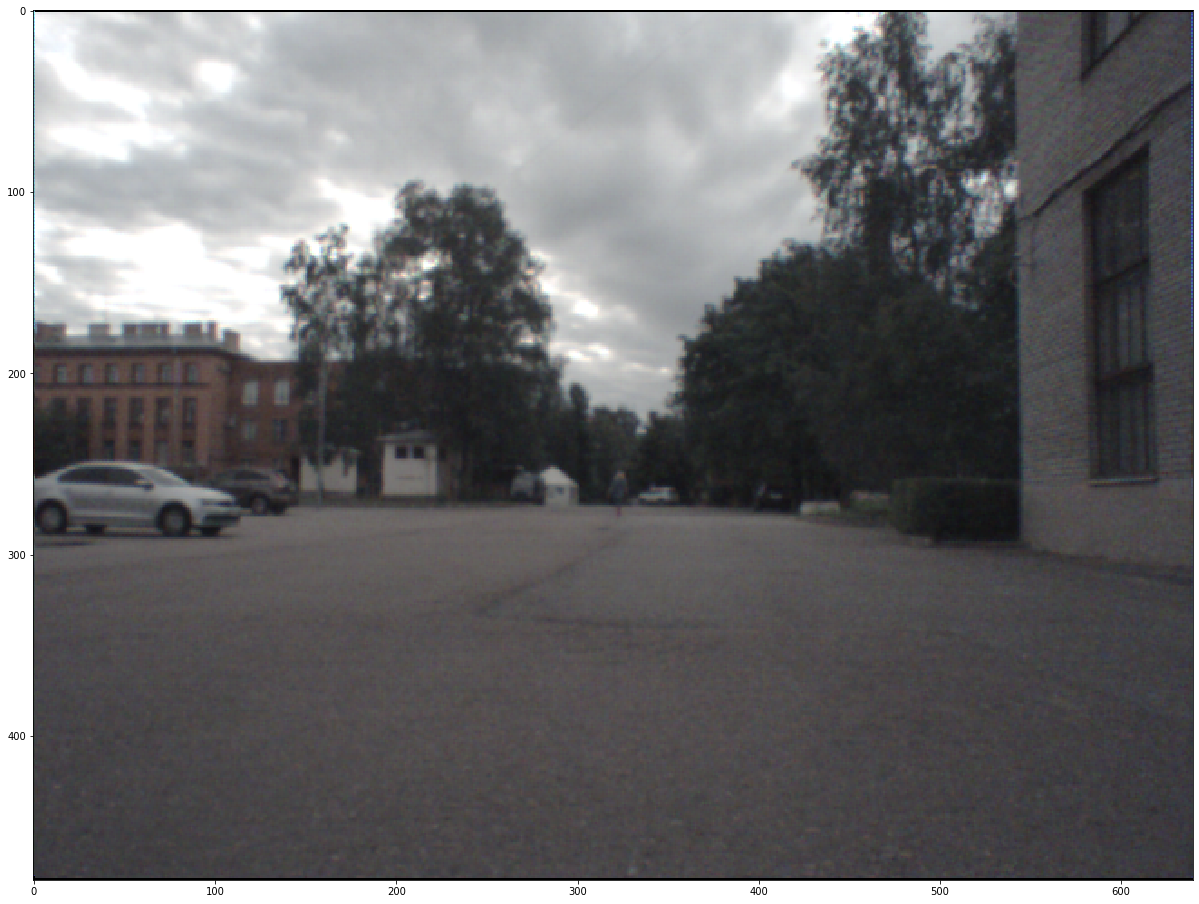

In [66]:
plt.imshow(img)
plt.show()

In [67]:
inference_transform = T.Compose([
    T.ToPILImage(),  # uncomment for usage with opencv images
#     T.Resize(480),
#     T.CenterCrop(512),
    T.ToTensor(), 
    torch_unsqueeze
])

In [68]:
out = net(inference_transform(img).cuda(2))

In [69]:
om = torch.argmax(out.squeeze(), dim=0).detach().cpu().numpy()
print (om.shape)
print (np.unique(om))
print (set([i.category for i in torchvision.datasets.Cityscapes.classes if i.category_id in np.unique(om)]))

(480, 640)
[0 1 2 4 5 6 7]
{'construction', 'human', 'nature', 'flat', 'sky', 'void', 'vehicle'}


In [70]:
city_mask = decode_cityscapes_out(om, category=True)

In [71]:
# img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
# img = inference_test_transform(img)

(480, 640, 3)
(480, 640, 3)


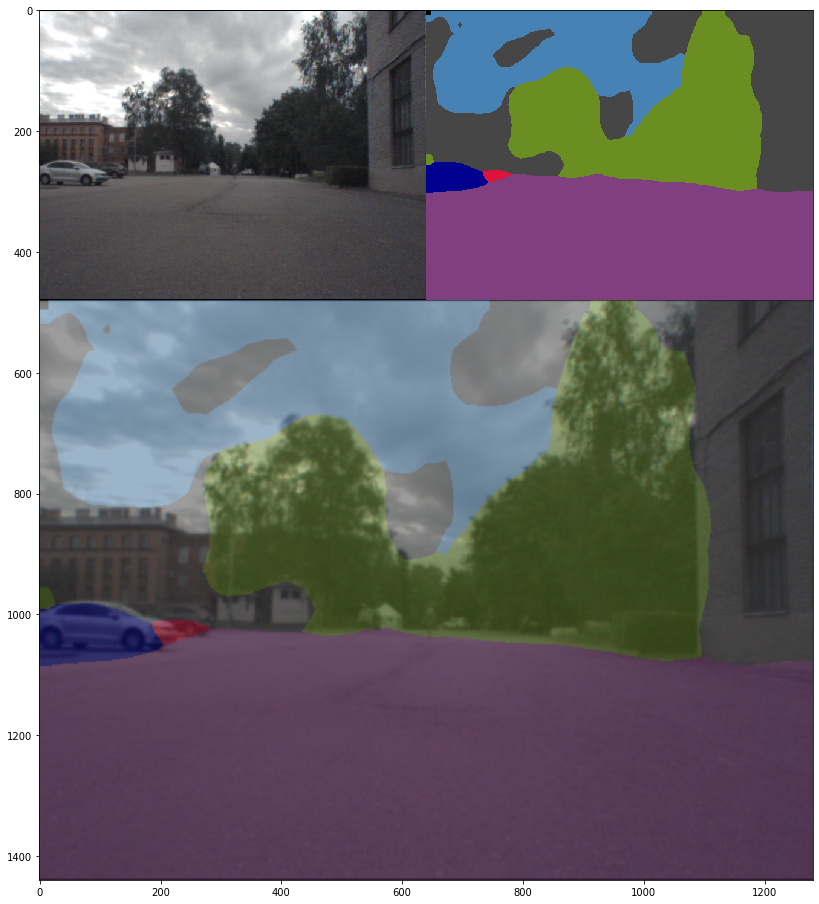

In [72]:
matplotlib.rcParams['figure.figsize'] = [40, 16]
print(img.shape)
print(city_mask.shape)
plt.imshow(
    np.vstack((
        np.hstack((img, city_mask)),
        cv.pyrUp(
            cv.addWeighted(img, 0.5, city_mask, 0.4, 0)))))
plt.show()

In [73]:
index = 11

(375, 1242)
['unlabeled', 'ego vehicle', 'rectification border', 'out of roi', 'static', 'dynamic', 'road']


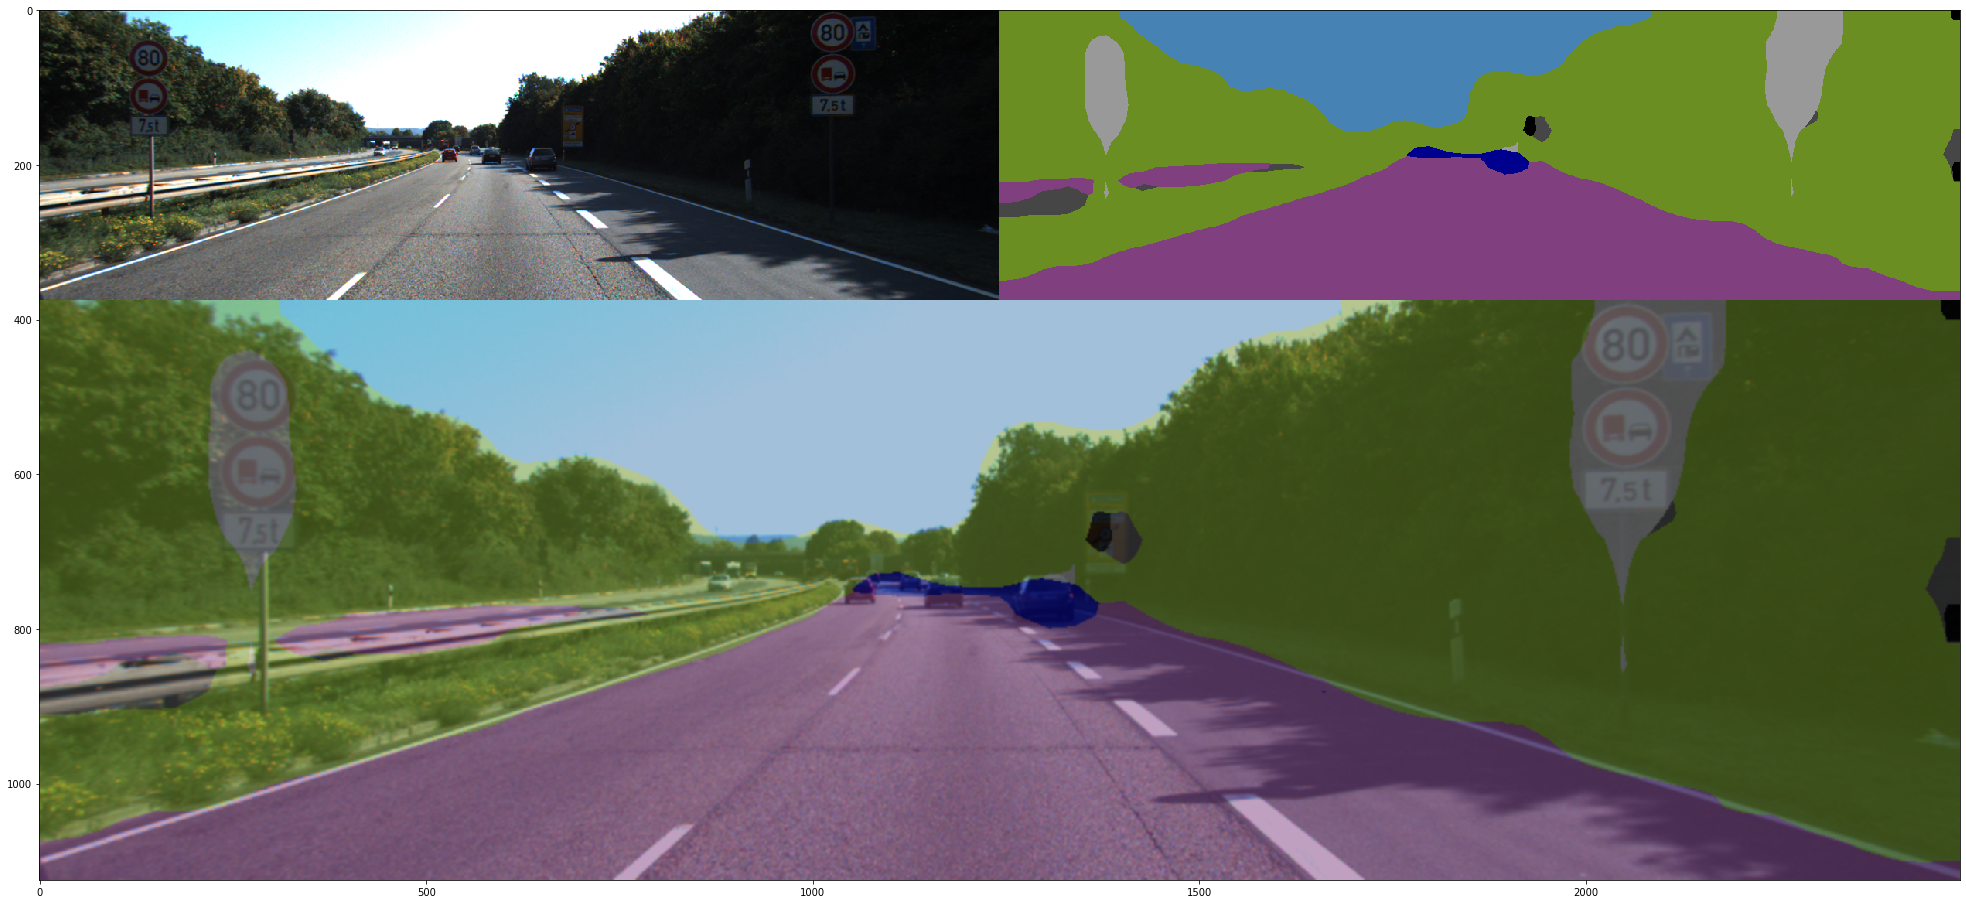

In [74]:
out = net(torch.unsqueeze(validation_dataset[index][0], dim=0).cuda(2))
om = torch.argmax(out.squeeze(), dim=0).detach().cpu().numpy()
print (om.shape)
print ([i.name for i in torchvision.datasets.Cityscapes.classes if i.id in np.unique(om)])
frame = cv.imread(validation_dataset.images[index])
frame = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
# frame = inference_test_transform(frame)
city_mask = decode_cityscapes_out(om, category=True)

torch.cuda.empty_cache()
plt.imshow(
    np.vstack((
        np.hstack((frame, city_mask)),
        cv.pyrUp(cv.addWeighted(frame, 0.5, city_mask, 0.5, 0)))))
plt.show()

In [75]:
sys.path.append('../depth_prediction/')
import networks
from utils import download_model_if_doesnt_exist
import os
import PIL.Image as pil


In [94]:
model_name = "mono_640x192"

download_model_if_doesnt_exist(model_name)
encoder_path = os.path.join("../depth_prediction/models", model_name, "encoder.pth")
depth_decoder_path = os.path.join("../depth_prediction/models", model_name, "depth.pth")

# LOADING PRETRAINED MODEL
encoder = networks.ResnetEncoder(18, False)
depth_decoder = networks.DepthDecoder(num_ch_enc=encoder.num_ch_enc, scales=range(4))

loaded_dict_enc = torch.load(encoder_path, map_location='cpu')
filtered_dict_enc = {k: v for k, v in loaded_dict_enc.items() if k in encoder.state_dict()}
encoder.load_state_dict(filtered_dict_enc)

loaded_dict = torch.load(depth_decoder_path, map_location='cpu')
depth_decoder.load_state_dict(loaded_dict)

encoder.cuda(2).eval()
depth_decoder.cuda(2).eval();

In [95]:
def get_frame_ROI(frame):
    return cv.cvtColor(cv.cvtColor(frame, cv.COLOR_BGR2RGB), cv.COLOR_RGB2BGR)

In [101]:
def get_frame_semantic(frame):
    out_tensor = net(input_transform(cv.cvtColor(frame, cv.COLOR_BGR2RGB)).cuda(2).unsqueeze(0))
    om = torch.argmax(out_tensor.squeeze(), dim=0).detach().cpu().numpy()
    city_mask = decode_cityscapes_out(om, category=True)
    return cv.cvtColor(city_mask, cv.COLOR_RGB2BGR)

In [135]:
def get_frame_disp_RGB(frame):
    input_image = T.ToPILImage()(cv.cvtColor(frame, cv.COLOR_BGR2RGB))
    original_width, original_height = input_image.size

    feed_height = loaded_dict_enc['height']
    feed_width = loaded_dict_enc['width']
    input_image_resized = input_image.resize((feed_width, feed_height), pil.LANCZOS)

    input_image_pytorch = T.ToTensor()(input_image_resized).unsqueeze(0)
    with torch.no_grad():
        features = encoder(input_image_pytorch.cuda(2))
        outputs = depth_decoder(features)

    disp = outputs[("disp", 0)].cpu()
    
    disp_resized = torch.nn.functional.interpolate(
        disp,
        (original_height, original_width), mode="bilinear", align_corners=False)
    
    # Saving colormapped depth image
    disp_resized_np = disp_resized.squeeze().cpu().numpy()
    vmax = np.percentile(disp_resized_np, 95)
#     return cv.applyColorMap((disp_resized_np*255).astype(np.uint8), cv.COLORMAP_HSV)
    return disp_resized_np*255

In [253]:
input_video_path = '../../data/VIDEO22.AVI'
input_cap = cv.VideoCapture(input_video_path)

In [254]:
output_video_path = '../../results/semantic/deeplab_resnet50_kitti_X264.mp4'
/
fourcc = cv.VideoWriter_fourcc(*'XVID')
fps = input_cap.get(cv.CAP_PROP_FPS)
fps = 10
print('fps:', fps)
output_cap = cv.VideoWriter(output_video_path, fourcc, fps, (1280,  960))
print(output_cap.isOpened())

fps: 10
True


In [255]:
%%time

index = 0
while True:
    print(' '*10, end='\r')
    print(index, end='\r')
    index += 1
    ret, frame = input_cap.read()
    if ret is not True:
        break
    frame_ROI = get_frame_ROI(frame)

    disp = get_frame_ROI(cv.applyColorMap((get_frame_disp_RGB(frame)).astype(np.uint8), cv.COLORMAP_HSV))

    sem = get_frame_semantic(frame)

    
    mask = np.zeros_like(sem[..., 1])
    mask[np.where(sem[..., 1] == 64)] = 255

    rows,cols = img.shape[:2]
    
    disp = get_frame_disp_RGB(frame)
#     print(disp.shape, disp.dtype)
    road = cv.bitwise_and(mask, disp.astype(np.uint8))

    contours,hierarchy = cv.findContours(mask, 1, cv.CHAIN_APPROX_NONE)
    max_area = 0
    max_cnt = None
    for cnt in contours:
        if cv.contourArea(cnt) > max_area:
            max_area = cv.contourArea(cnt)
            max_cnt = cnt

    center_line = np.zeros((480, 2), dtype=np.int32)
    center_line[..., 0] = 640
    
    frame_copy = frame_ROI.copy()
    
    if max_cnt is not None:
        for pt in max_cnt:
            pt = pt[0]
            frame_copy[pt[1], pt[0]] = (0, 255, 0)
            center_line[pt[1], 0] = min(center_line[pt[1], 0], pt[0])
            center_line[pt[1], 1] = max(center_line[pt[1], 1], pt[0])

#     print(max_cnt)
    for y, pt in enumerate(center_line):
        if pt[1] != 0 and pt[0] != 640:
            cv.circle(frame_copy, (int((pt[1]-pt[0])/2+pt[0]), y), 3, (0, 255, 0), cv.FILLED)

    mask = np.zeros_like(sem)
    mask[np.where(sem[..., 1] == 64)] = 255

    result = cv.applyColorMap(road, cv.COLORMAP_HSV)
    result = cv.bitwise_and(mask, result)
#     print(result.shape, frame_ROI.shape, sem.shape, disp.shape)
    disp = cv.applyColorMap(disp.astype(np.uint8), cv.COLORMAP_HSV)
    result = cv.addWeighted(result.astype(np.uint8), 0.4, frame_ROI, 1, 0)
    result = np.vstack((
        np.hstack((frame_copy, sem)),
        np.hstack((disp, result))))
#     print(result.shape)
#     plt.imshow(result)
#     plt.show()
#     break
    output_cap.write(result)
    
print()

2143      
CPU times: user 22min 52s, sys: 8.78 s, total: 23min 1s
Wall time: 2min 44s


In [256]:

output_cap.release()

In [258]:
2143/164

13.067073170731707

<video controls src="../../results/semantic/deeplab_resnet50_kitti_X264.mp4" />

In [ ]:
#Don't forget
import torch
from torch.nn import CrossEntropyLoss
import numpy as np

out = torch.Tensor(np.array([[
    [
        [1.,1, 1], 
        [0, 0, 0], 
        [0, 0, 0],
        [0, 0, 0]
    ],
    [
        [0, 0, 0],
        [1, 1, 1],
        [0, 0.,0],
        [0, 0, 0]
    ],
    [
        [0, 0, 0],
        [0, 0, 0],
        [1, 1, 1],
        [0, 0, 0]
    ],
    [
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [1, 1.0, 1]
    ]
]]))

target = torch.Tensor([[
    [0, 0, 0],
    [1, 1, 1],
    [2, 2, 2],
    [3, 3, 3]
]]).type('torch.LongTensor')

print(out.shape, target.shape)
criterion = CrossEntropyLoss()
print(criterion(out, target))